<a href="https://colab.research.google.com/github/Damiao97/assignment4_pml/blob/main/Assignment_Class_05_04_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [100/500], Train Loss: 1.1362, Test Loss: 1.1465
Epoch [200/500], Train Loss: 1.0538, Test Loss: 1.1496
Epoch [300/500], Train Loss: 1.1413, Test Loss: 1.0488
Epoch [400/500], Train Loss: 1.2261, Test Loss: 1.1975
Epoch [500/500], Train Loss: 1.2615, Test Loss: 1.2403


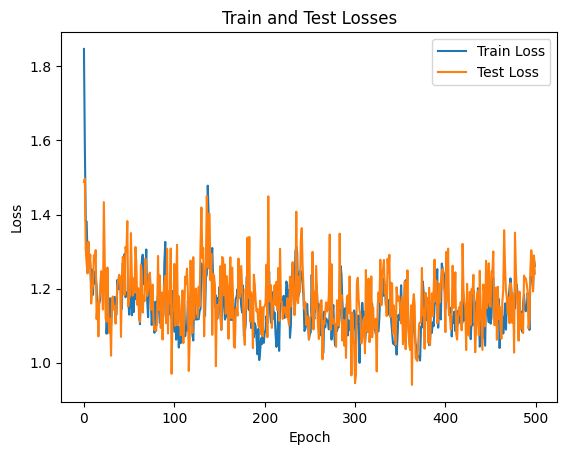

Accuracy on test set: 0.5389


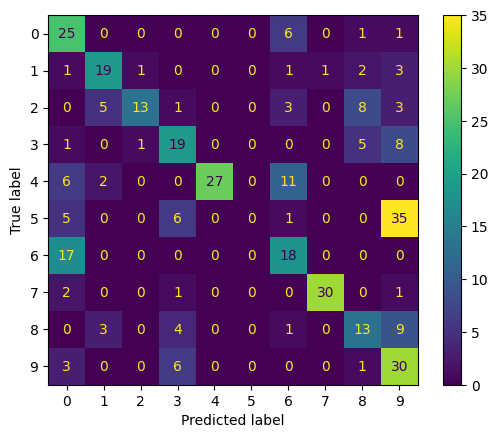

In [5]:
#@title Script that implements a neural network with PyTorch (over the iris or mnist datasets)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

CREATE_CLASS=True # Create class from scratch; otherwise use nn.Sequential to create the class
SGD=False # SGD or Adam
IRIS=False # iris or mnist
SHOW=False # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
    if SHOW:
        idx=random.randint(0,len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8,8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 8
output_size = len(examples.target_names)
batch_size=120
num_epochs = 500
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
momentum_param=0.9
# Dropout: if p>0
dropout_p=0.25 # During training, randomly zeroes some of the elements of the input tensor with probability p.

# Create dataloader which makes it easier to use mini batches
train_dl=DataLoader(TensorDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)

########################################################### NN model
if CREATE_CLASS:
    # Create model, first defining the class with a forward method
    class ThreeLayerNet(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer with dropout probability
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)  # Apply dropout after first hidden layer
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)  # Apply dropout after second hidden layer
            x = self.fc3(x)
            return x
    model = ThreeLayerNet(input_size, hidden_size, output_size)
else:
    # Or, in alternative, use nn.Sequential
    model=nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(hidden_size, output_size)
    )
####################################################################################################
# Define loss function and optimizer
# Either torch.nn.NLLLoss or torch.nn.CrossEntropyLoss can be used: CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) implements softmax internally
criterion = nn.CrossEntropyLoss() #
# Optimizer: optimizer object that will hold the current state and will update the parameters based on the computed gradients
# for param in model.parameters(): print(param.data)
if SGD:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=regularization_param, momentum=momentum_param)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Lists to store train and test losses
train_losses = []
test_losses = []

# Training the model
for epoch in range(num_epochs):
    train_loss = 0.0
    for x_batch, y_batch in train_dl:
        # Forward pass
        pred = model(x_batch) # Returns tensor: nrows=tensor batch_size; ncols=number of classes
        loss = criterion(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad() # Resets the gradients of all optimized tensors
        loss.backward() # Computes gradient
        optimizer.step() # Performs a single optimization step (parameter update).

        train_loss += loss.item() # .item() extracts the scalar value of the loss tensor

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # Test the model
    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plotting train and test losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

# Testing the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1) # Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).

actual=y_test_tensor.numpy()
pred=predicted.numpy()
accuracy = accuracy_score(actual, pred)
print(f'Accuracy on test set: {accuracy:.4f}')
cm=confusion_matrix(actual, pred)
labels = np.unique(actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

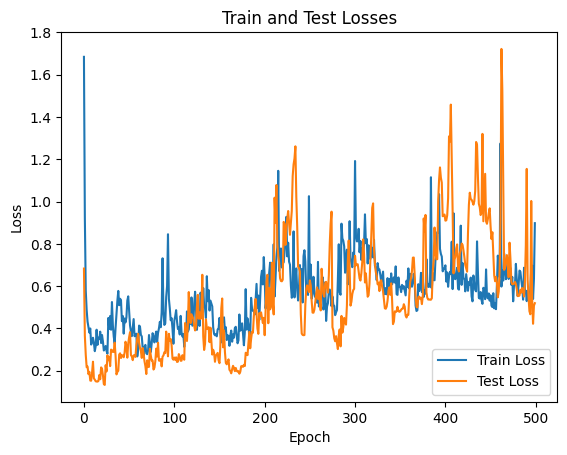

12/12 [==============================] - 0s 2ms/step
Accuracy on test set: 0.8806


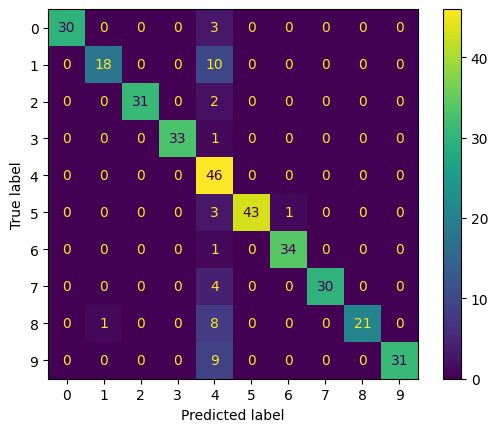

In [14]:
import tensorflow as tf
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random
import numpy as np

CREATE_CLASS = True  # Create class from scratch; otherwise use nn.Sequential to create the class
SGD = False  # SGD or Adam
IRIS = False  # iris or mnist
SHOW = False  # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits()  # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
    if SHOW:
        idx = random.randint(0, len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8, 8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8, 8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Define the model
input_size = X_train_tensor.shape[1]
hidden_size = 20
output_size = len(examples.target_names)
dropout_p = 0.15  # Dropout probability

if CREATE_CLASS:
    class ThreeLayerNet(tf.keras.Model):
        def __init__(self):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.dropout1 = tf.keras.layers.Dropout(dropout_p)
            self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.dropout2 = tf.keras.layers.Dropout(dropout_p)
            self.fc3 = tf.keras.layers.Dense(output_size)

        def call(self, inputs):
            x = self.fc1(inputs)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.dropout2(x)
            return self.fc3(x)

    model = ThreeLayerNet()
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(output_size)
    ])

# Define loss function and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
if SGD:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


# Train the model with validation data
history = model.fit(X_train_tensor, y_train_tensor, epochs=500, batch_size=250, verbose=0, validation_data=(X_test_tensor, y_test_tensor))

# Plotting train and test losses
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


# Testing the model
y_pred_prob = model.predict(X_test_tensor)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.4f}')

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
